# 효율적인 하위 픽셀 CNN을 사용한 이미지 초해상도

**Author:** [Xingyu Long](https://github.com/xingyu-long)<br>
**Date created:** 2020/07/28<br>
**Last modified:** 2020/08/27<br>
**Description:** BSDS500에서 Efficient sub-pixel 모델을 사용하여 Super-Resolution을 구현합니다.

## 소개

[Shi, 2016](https://arxiv.org/abs/1609.05158)이 제안한 ESPCN(Efficient Sub-Pixel CNN)은 저해상도 버전이 주어진 이미지의 고해상도 버전을 재구성하는 모델입니다.<br>
이미지 업스케일링 필터 배열을 학습하는 효율적인 "하위 픽셀 컨볼루션" 레이어를 활용합니다.<br><br>

이 코드 예제에서는 논문에서 모델을 구현하고 작은 데이터 세트에서 훈련할 것입니다.<br>
[BSDS500](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html).

## 설정

In [19]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

## 데이터 로드: BSDS500 데이터 세트

### 데이터세트 다운로드

내장된 `keras.utils.get_file` 유틸리티를 사용하여 데이터세트를 검색합니다.

In [20]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

우리는 `image_dataset_from_directory`를 통해 훈련 및 검증 데이터 세트를 생성합니다.

In [21]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


[0, 1] 범위의 값을 사용하도록 이미지의 크기를 조정합니다.

In [22]:

def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

몇 가지 샘플 이미지를 시각화해 보겠습니다.

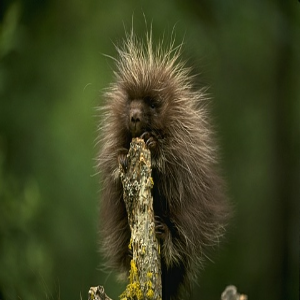

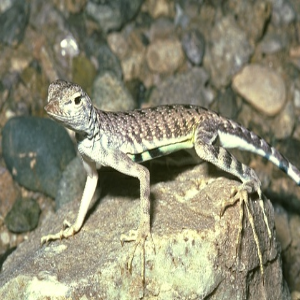

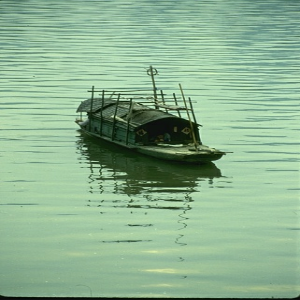

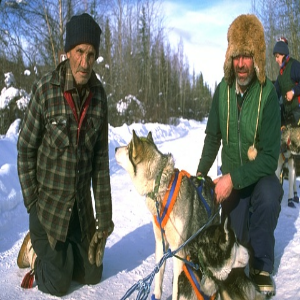

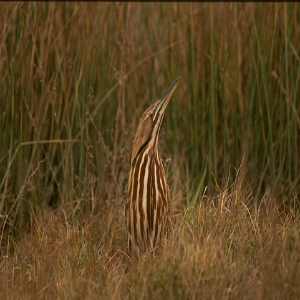

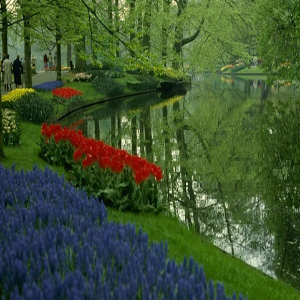

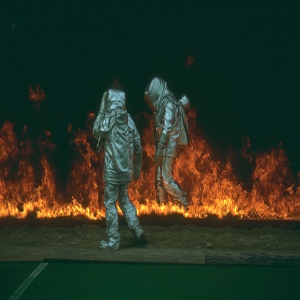

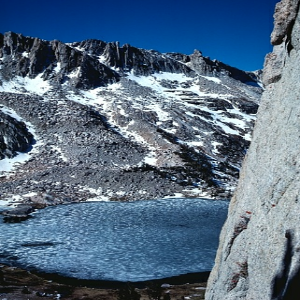

In [6]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

사용할 테스트 이미지 경로 데이터 세트를 준비합니다.<br>
이 예의 끝에 있는 시각적 평가.

In [23]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

## 이미지 자르기 및 크기 조정

이미지 데이터를 처리합시다.<br>
먼저 RGB 색상 공간에서 이미지를 변환합니다.<br>
[YUV 색 공간](https://en.wikipedia.org/wiki/YUV).<br><br>

입력 데이터(저해상도 이미지)의 경우,
이미지를 자르고 'y' 채널(휘도)을 검색합니다.<br>
'area' 방법으로 크기를 조정합니다(PIL을 사용하는 경우 'BICUBIC' 사용).<br>
우리는 휘도 채널만을 고려합니다<br>
인간이 더 민감하기 때문에 YUV 색 공간에서
휘도 변화.<br><br>

대상 데이터(고해상도 이미지)의 경우 이미지를 자릅니다.<br>
'y' 채널을 검색합니다.

In [24]:

# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

입력 및 대상 데이터를 살펴보겠습니다.

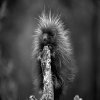

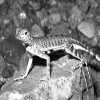

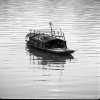

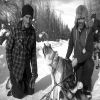

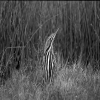

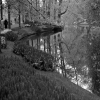

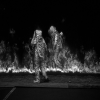

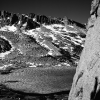

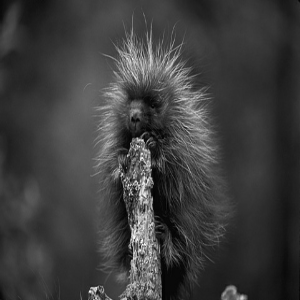

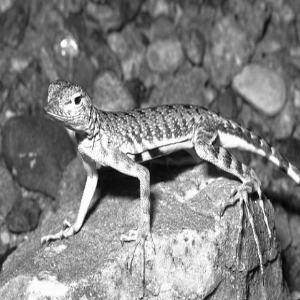

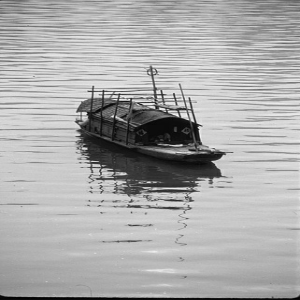

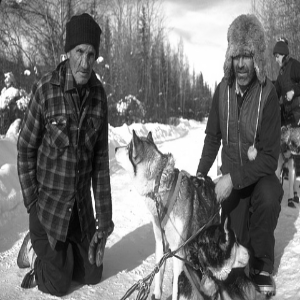

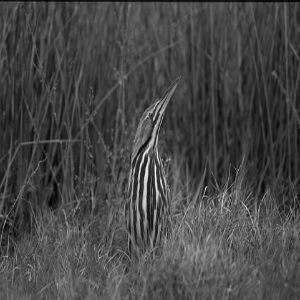

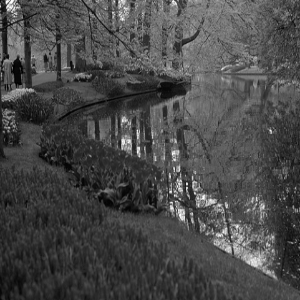

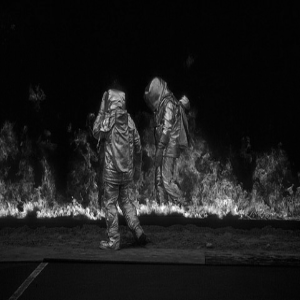

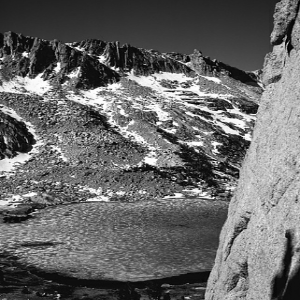

In [25]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

## 모델 구축

논문에 비해 레이어를 하나 더 추가하고 `tanh` 대신 `relu` 활성화 함수를 사용합니다.<br>
더 적은 에포크 동안 모델을 훈련하더라도 더 나은 성능을 달성합니다.

In [26]:

def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


## 유틸리티 기능 정의

결과를 모니터링하려면 몇 가지 유틸리티 함수를 정의해야 합니다.

- `plot_results`는 저장 이미지를 플롯합니다.
- 이미지를 저해상도 버전으로 변환하는 `get_lowres_image`.
- 저해상도 이미지를 다음으로 변환하는 `upscale_image`
모델에 의해 재구성된 고해상도 버전.<br>
이 함수에서는 YUV 색상 공간의 'y' 채널을 사용합니다.<br>
모델에 대한 입력으로 출력을 결합한 다음
RGB 이미지를 얻기 위해 다른 채널.

480 321


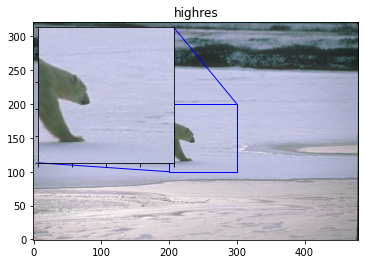

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

for index, test_img_path in enumerate(test_img_paths[:1]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    print(w,h)
    highres_img = img.resize((w, h))

    img_array = img_to_array(highres_img)
    img_array = img_array.astype("float32") / 255.0
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")
    plt.title("highres")
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")
    
        # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.show()

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


## 훈련 모니터링을 위한 콜백 정의

'ESPCNCallback' 객체는 계산하고 표시합니다.<br>
[PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) 측정항목입니다.<br>
이것은 우리가 초해상도 성능을 평가하는 데 사용하는 주요 메트릭입니다.

In [28]:

class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


'ModelCheckpoint' 및 'EarlyStopping' 콜백을 정의합니다.

In [29]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "./checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 64)    1664      
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 32)    18464     
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space_2 (TFO  (None, None, None, 1)    0         
 pLambda)                                                        
                                                           

## 모델 훈련

Epoch 1/100
Mean PSNR for epoch: 14.77


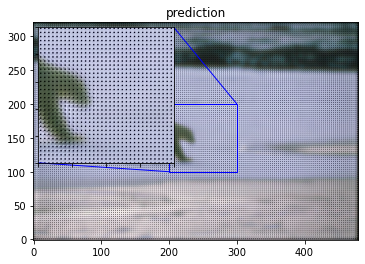

50/50 - 10s - loss: 0.0665 - val_loss: 0.0336 - 10s/epoch - 209ms/step
Epoch 2/100
Mean PSNR for epoch: 22.22
50/50 - 10s - loss: 0.0245 - val_loss: 0.0058 - 10s/epoch - 209ms/step
Epoch 3/100
Mean PSNR for epoch: 24.95
50/50 - 11s - loss: 0.0047 - val_loss: 0.0033 - 11s/epoch - 219ms/step
Epoch 4/100
Mean PSNR for epoch: 26.09
50/50 - 10s - loss: 0.0034 - val_loss: 0.0028 - 10s/epoch - 210ms/step
Epoch 5/100
Mean PSNR for epoch: 25.86
50/50 - 11s - loss: 0.0032 - val_loss: 0.0027 - 11s/epoch - 217ms/step
Epoch 6/100
Mean PSNR for epoch: 26.21
50/50 - 11s - loss: 0.0029 - val_loss: 0.0025 - 11s/epoch - 213ms/step
Epoch 7/100
Mean PSNR for epoch: 26.25
50/50 - 11s - loss: 0.0028 - val_loss: 0.0025 - 11s/epoch - 213ms/step
Epoch 8/100
Mean PSNR for epoch: 26.26
50/50 - 11s - loss: 0.0028 - val_loss: 0.0025 - 11s/epoch - 219ms/step
Epoch 9/100
Mean PSNR for epoch: 26.25
50/50 - 11s - loss: 0.0028 - val_loss: 0.0025 - 11s/epoch - 219ms/step
Epoch 10/100
Mean PSNR for epoch: 26.24
50/50 - 1

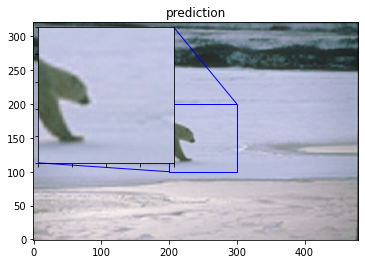

50/50 - 11s - loss: 0.0028 - val_loss: 0.0024 - 11s/epoch - 230ms/step
Epoch 22/100
Mean PSNR for epoch: 26.22
50/50 - 11s - loss: 0.0027 - val_loss: 0.0024 - 11s/epoch - 229ms/step
Epoch 23/100
Mean PSNR for epoch: 26.61
50/50 - 11s - loss: 0.0026 - val_loss: 0.0023 - 11s/epoch - 227ms/step
Epoch 24/100
Mean PSNR for epoch: 26.67
50/50 - 11s - loss: 0.0026 - val_loss: 0.0023 - 11s/epoch - 224ms/step
Epoch 25/100
Mean PSNR for epoch: 26.96
50/50 - 11s - loss: 0.0026 - val_loss: 0.0024 - 11s/epoch - 224ms/step
Epoch 26/100
Mean PSNR for epoch: 26.29
50/50 - 11s - loss: 0.0026 - val_loss: 0.0023 - 11s/epoch - 224ms/step
Epoch 27/100
Mean PSNR for epoch: 27.18
50/50 - 11s - loss: 0.0026 - val_loss: 0.0023 - 11s/epoch - 226ms/step
Epoch 28/100
Mean PSNR for epoch: 26.52
50/50 - 11s - loss: 0.0026 - val_loss: 0.0023 - 11s/epoch - 229ms/step
Epoch 29/100
Mean PSNR for epoch: 26.51
50/50 - 11s - loss: 0.0026 - val_loss: 0.0024 - 11s/epoch - 228ms/step
Epoch 30/100
Mean PSNR for epoch: 26.43
5

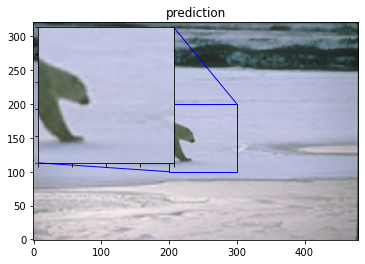

50/50 - 12s - loss: 0.0026 - val_loss: 0.0023 - 12s/epoch - 237ms/step
Epoch 42/100
Mean PSNR for epoch: 26.70
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023 - 12s/epoch - 231ms/step
Epoch 43/100
Mean PSNR for epoch: 26.83
50/50 - 11s - loss: 0.0025 - val_loss: 0.0023 - 11s/epoch - 229ms/step
Epoch 44/100
Mean PSNR for epoch: 26.81
50/50 - 11s - loss: 0.0026 - val_loss: 0.0023 - 11s/epoch - 228ms/step
Epoch 45/100
Mean PSNR for epoch: 26.42
50/50 - 11s - loss: 0.0029 - val_loss: 0.0023 - 11s/epoch - 229ms/step
Epoch 46/100
Mean PSNR for epoch: 26.27
50/50 - 11s - loss: 0.0025 - val_loss: 0.0023 - 11s/epoch - 227ms/step
Epoch 47/100
Mean PSNR for epoch: 26.57
50/50 - 11s - loss: 0.0025 - val_loss: 0.0023 - 11s/epoch - 230ms/step
Epoch 48/100
Mean PSNR for epoch: 26.34
50/50 - 12s - loss: 0.0025 - val_loss: 0.0023 - 12s/epoch - 233ms/step
Epoch 49/100
Mean PSNR for epoch: 26.54
50/50 - 11s - loss: 0.0025 - val_loss: 0.0023 - 11s/epoch - 230ms/step
Epoch 50/100
Mean PSNR for epoch: 26.43
5

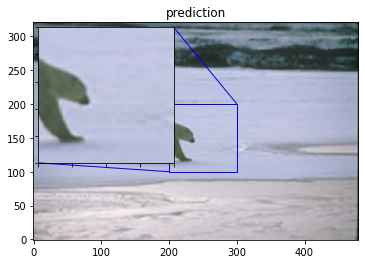

50/50 - 12s - loss: 0.0025 - val_loss: 0.0022 - 12s/epoch - 243ms/step
Epoch 62/100
Mean PSNR for epoch: 26.28
50/50 - 11s - loss: 0.0025 - val_loss: 0.0022 - 11s/epoch - 229ms/step
Epoch 63/100
Mean PSNR for epoch: 26.27
50/50 - 11s - loss: 0.0025 - val_loss: 0.0023 - 11s/epoch - 227ms/step
Epoch 64/100
Mean PSNR for epoch: 27.33
50/50 - 11s - loss: 0.0025 - val_loss: 0.0022 - 11s/epoch - 229ms/step
Epoch 65/100
Mean PSNR for epoch: 26.89
50/50 - 11s - loss: 0.0025 - val_loss: 0.0022 - 11s/epoch - 228ms/step
Epoch 66/100
Mean PSNR for epoch: 26.42
50/50 - 11s - loss: 0.0025 - val_loss: 0.0022 - 11s/epoch - 224ms/step
Epoch 67/100
Mean PSNR for epoch: 25.57
50/50 - 11s - loss: 0.0031 - val_loss: 0.0029 - 11s/epoch - 226ms/step
Epoch 68/100
Mean PSNR for epoch: 26.70
50/50 - 11s - loss: 0.0026 - val_loss: 0.0022 - 11s/epoch - 227ms/step
Epoch 69/100
Mean PSNR for epoch: 26.44
50/50 - 11s - loss: 0.0025 - val_loss: 0.0022 - 11s/epoch - 228ms/step
Epoch 70/100
Mean PSNR for epoch: 26.72
5

KeyboardInterrupt: 

In [30]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

## 모델 예측 실행 및 결과 플롯

몇 가지 이미지의 재구성된 버전을 계산하고 결과를 저장해 보겠습니다.

PSNR of low resolution image and high resolution image is 29.8502
PSNR of predict and high resolution is 30.4412


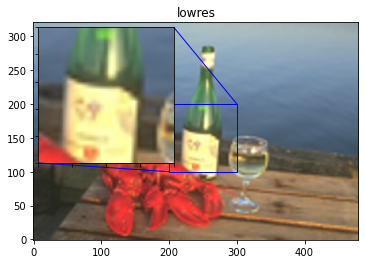

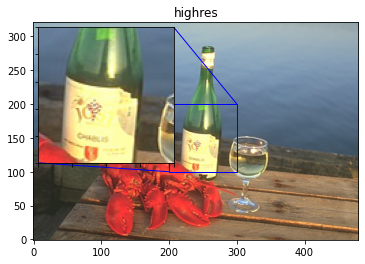

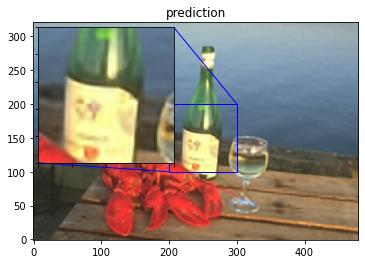

PSNR of low resolution image and high resolution image is 24.9783
PSNR of predict and high resolution is 25.9576


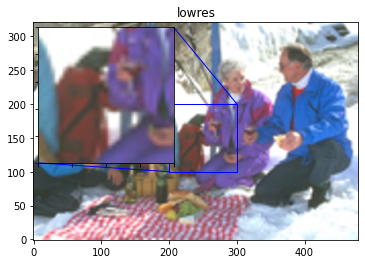

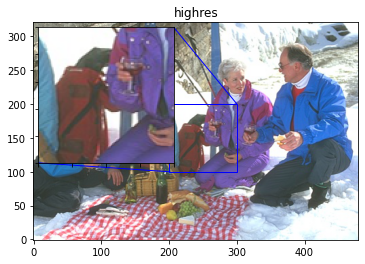

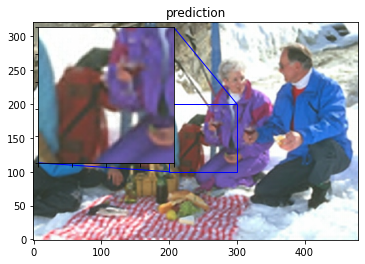

PSNR of low resolution image and high resolution image is 27.7724
PSNR of predict and high resolution is 28.4018


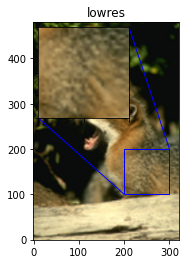

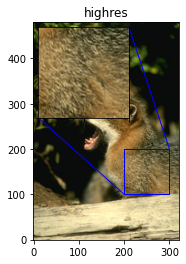

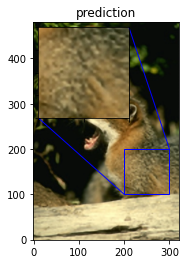

PSNR of low resolution image and high resolution image is 28.0314
PSNR of predict and high resolution is 28.2953


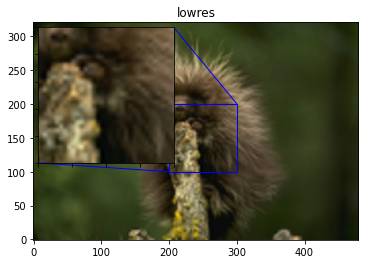

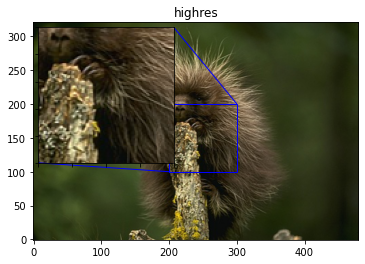

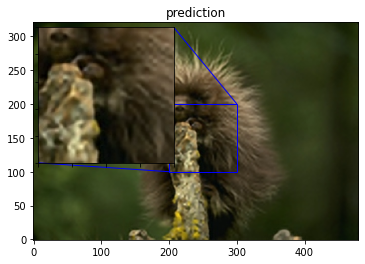

PSNR of low resolution image and high resolution image is 25.7630
PSNR of predict and high resolution is 26.3516


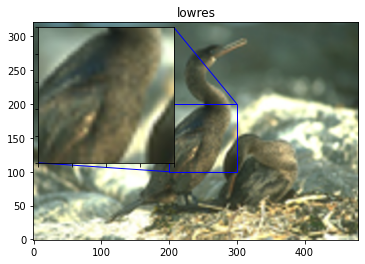

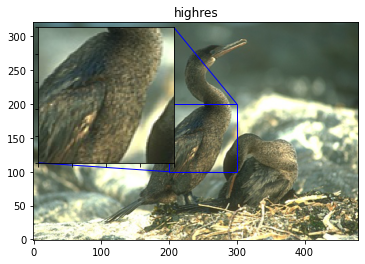

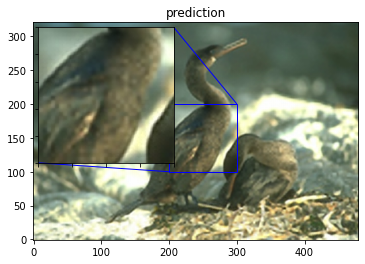

PSNR of low resolution image and high resolution image is 25.7874
PSNR of predict and high resolution is 26.6007


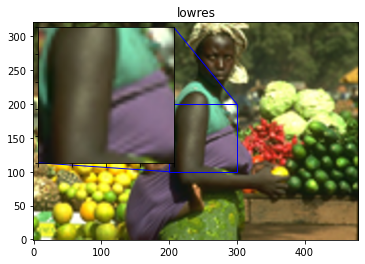

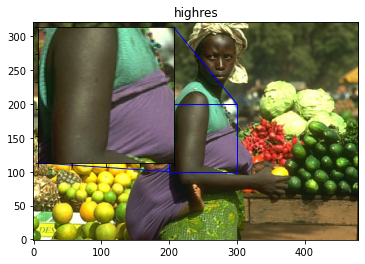

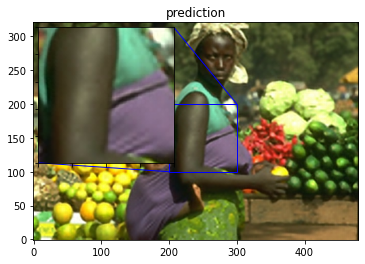

PSNR of low resolution image and high resolution image is 26.2512
PSNR of predict and high resolution is 27.1591


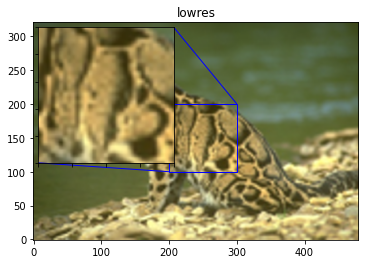

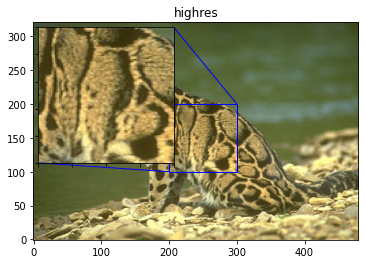

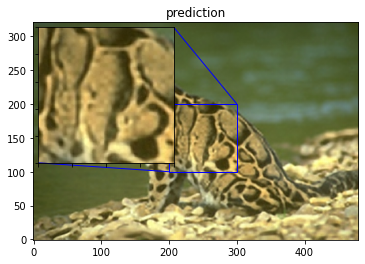

PSNR of low resolution image and high resolution image is 23.3820
PSNR of predict and high resolution is 24.7365


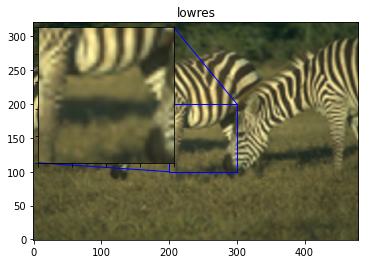

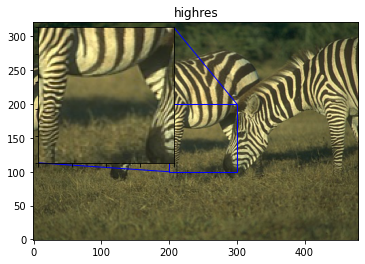

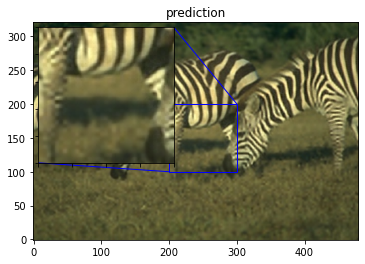

PSNR of low resolution image and high resolution image is 29.8914
PSNR of predict and high resolution is 30.0918


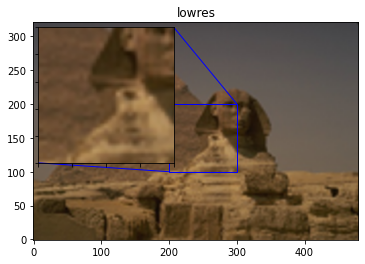

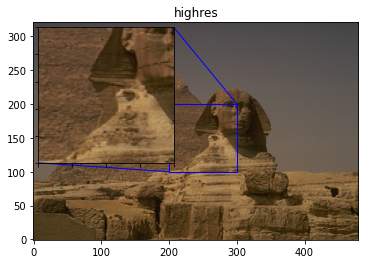

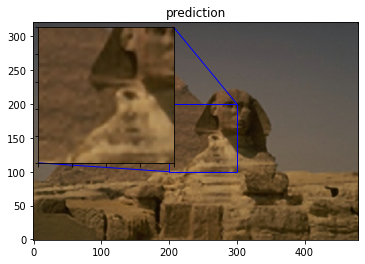

PSNR of low resolution image and high resolution image is 25.1712
PSNR of predict and high resolution is 25.7044


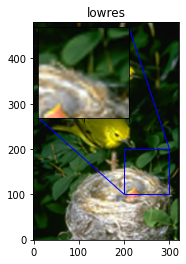

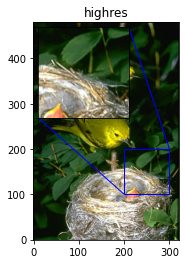

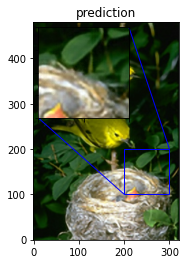

Avg. PSNR of lowres images is 26.6879
Avg. PSNR of reconstructions is 27.3740


In [18]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))